In [2]:
# Import Libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.datasets import mnist #svhn doesnot exist in keras dataset
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import datasets, layers, models
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model, clone_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.utils.vis_utils import plot_model

from scipy.io import loadmat
import cv2


## Load saved model

In [3]:
# By using load_model, we load the architecture as well as the weight of the saved model
base_model = tf.keras.models.load_model('/kaggle/input/cnn-mnist/kaggle/working/model/cnn_mnist')

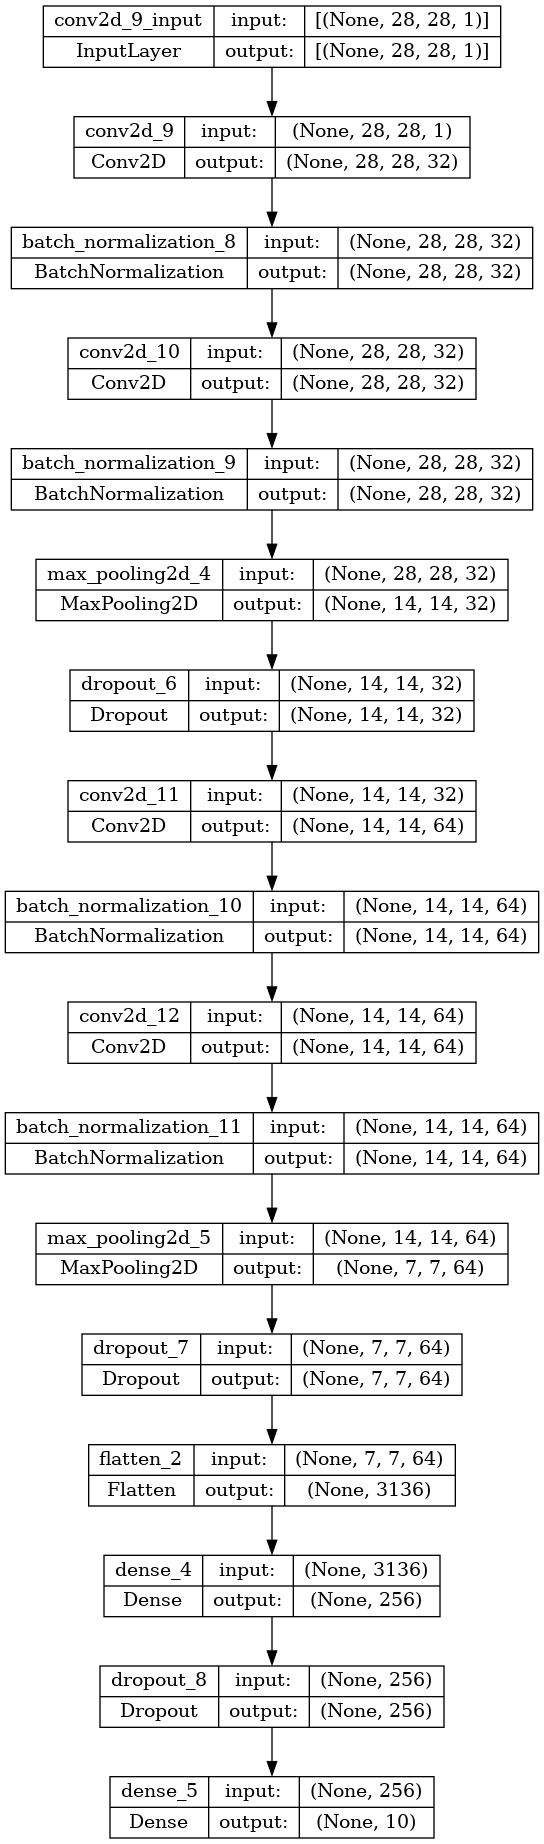

In [4]:
plot_model(base_model, show_shapes=True, show_layer_names=True)

## Download and Prepare SVHN Data

In [5]:
# Since SVHN dataset is not there in Keras dataset, we downloaded the same from Kaggle by using the option on right "Add Data" and searching for "svhn"
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/svhndataset/train_32x32.mat
/kaggle/input/svhndataset/test_32x32.mat
/kaggle/input/svhndataset/extra_32x32.mat
/kaggle/input/cnn-mnist/kaggle/working/model/cnn_mnist/fingerprint.pb
/kaggle/input/cnn-mnist/kaggle/working/model/cnn_mnist/saved_model.pb
/kaggle/input/cnn-mnist/kaggle/working/model/cnn_mnist/keras_metadata.pb
/kaggle/input/cnn-mnist/kaggle/working/model/cnn_mnist/variables/variables.index
/kaggle/input/cnn-mnist/kaggle/working/model/cnn_mnist/variables/variables.data-00000-of-00001


### Load data and prepocessing

In [6]:
train_raw = loadmat('../input/svhndataset/train_32x32.mat')
test_raw = loadmat('../input/svhndataset/test_32x32.mat')

In [7]:
train_raw

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[[[ 33,  84,  19, ...,  92, 190, 216],
          [ 30,  76,  54, ...,  78, 188, 217],
          [ 38,  59, 110, ..., 101, 191, 212]],
 
         [[ 15,  86,  20, ...,  94, 205, 221],
          [ 23,  73,  52, ...,  82, 203, 222],
          [ 19,  66, 111, ..., 105, 206, 217]],
 
         [[ 15,  77,  25, ..., 114, 220, 226],
          [ 17,  78,  57, ..., 101, 218, 227],
          [ 19,  56, 116, ..., 125, 220, 221]],
 
         ...,
 
         [[ 72,  90,  65, ..., 200, 229, 200],
          [ 65,  78, 144, ..., 201, 231, 199],
          [ 56,  69, 223, ..., 203, 224, 191]],
 
         [[ 82,  88,  78, ..., 192, 229, 193],
          [ 77,  77, 148, ..., 193, 229, 188],
          [ 57,  67, 218, ..., 195, 224, 182]],
 
         [[ 89,  88,  98, ..., 190, 229, 197],
          [ 79,  78, 158, ..., 191, 228, 189],
          [ 59,  66, 220, 

In [8]:
# Load images and labels

x_train = np.array(train_raw['X'])
x_test = np.array(test_raw['X'])

y_train = train_raw['y']
y_test = test_raw['y']


In [9]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 1)
(26032, 1)


In [10]:
# Fix the axes of the images

x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)

print(x_train.shape)
print(x_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [11]:
# Preprocess SVHN data
x_train = np.mean(x_train, axis=-1)
x_test = np.mean(x_test, axis=-1)


In [12]:
print(x_train.shape)
print(x_test.shape)

(73257, 32, 32)
(26032, 32, 32)


### Visualize the dataset

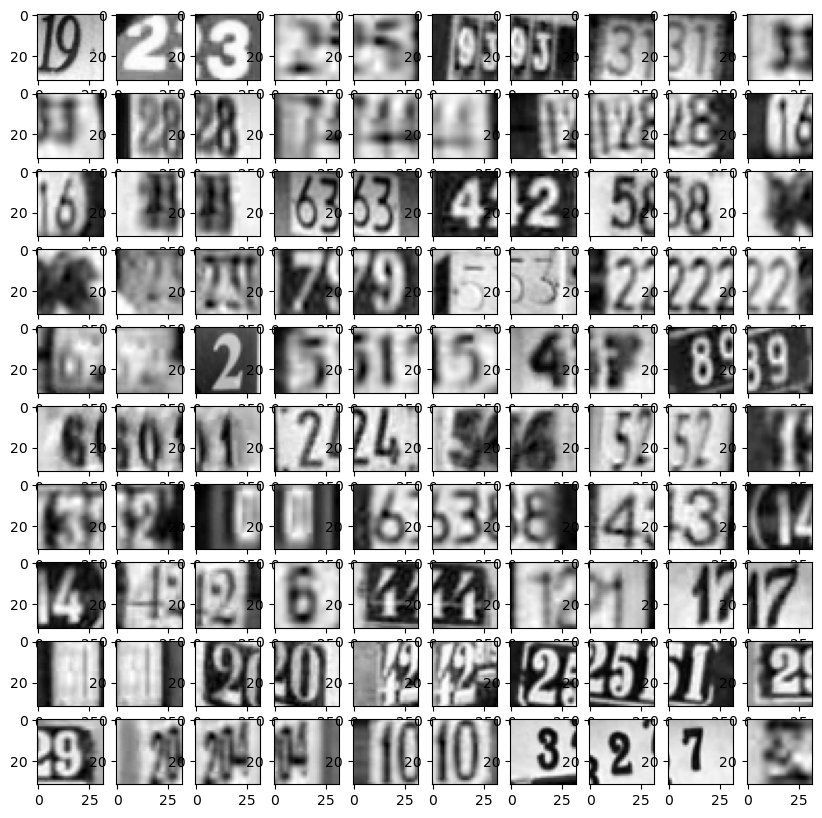

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,10))

rows = 10
columns = 10
w = 10
h = 10

for i in range(1, rows * columns + 1):
    img = x_train[i]
    fig.add_subplot(rows, columns,i)
    plt.imshow(img, cmap = 'gray')
plt.show()

In [14]:
# Convert the dimension (32, 32) to (28, 28)
#Create zero array for x_train, x_test
x_train_res = np.zeros((x_train.shape[0], 28,28), dtype = np.float32) #create a zero array of size 28*28 same as MNIST
x_test_res = np.zeros((x_test.shape[0], 28, 28), dtype = np.float32)

for i in range(x_train.shape[0]):
    x_train_res[i,:,:] = cv2.resize(x_train[i], dsize = (28,28), interpolation = cv2.INTER_CUBIC)
    
for i in range(x_test.shape[0]):
    x_test_res[i,:,:] = cv2.resize(x_test[i], dsize = (28,28), interpolation = cv2.INTER_CUBIC)
    
print(x_train_res.shape)
print(x_test_res.shape)

(73257, 28, 28)
(26032, 28, 28)


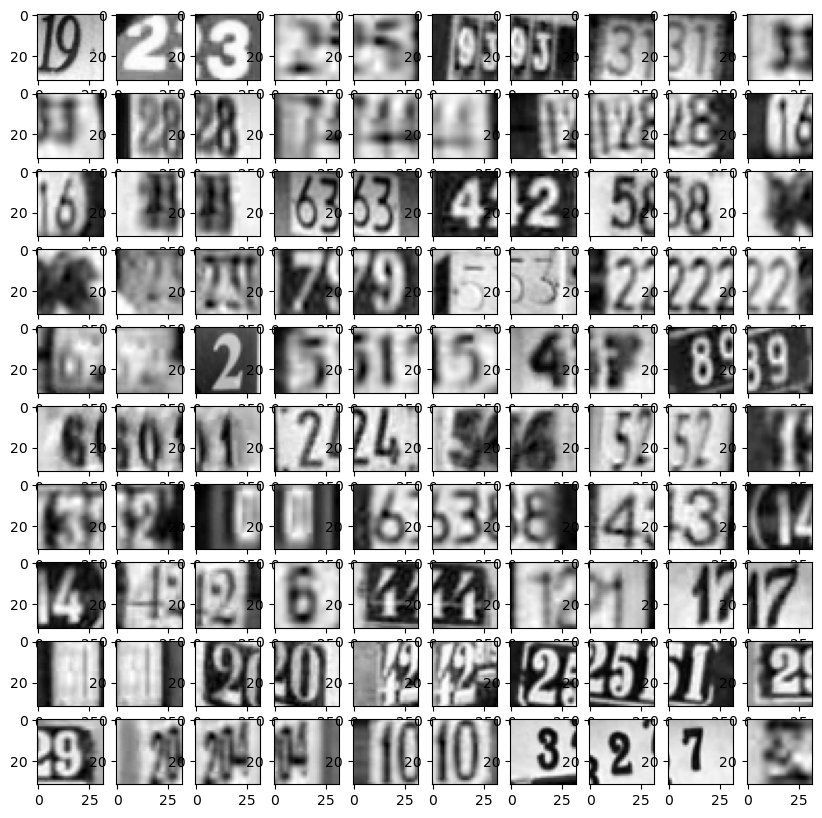

In [15]:
#Visualise again to check
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,10))

rows = 10
columns = 10
w = 10
h = 10

for i in range(1, rows * columns + 1):
    img = x_train[i]
    fig.add_subplot(rows, columns,i)
    plt.imshow(img, cmap = 'gray')
plt.show()

In [16]:
#Prepare the image data to be same as input size for the CNN model, i.e. (28, 28, 1)
img_rows, img_cols = 28, 28

x_train_svhn = x_train_res.reshape(x_train_res.shape[0], img_rows, img_cols, 1)
print(x_train_svhn.shape)
x_test_svhn = x_test_res.reshape(x_test_res.shape[0], img_rows, img_cols, 1)
print(x_test_svhn.shape)

#Shape of 1 image would be as given below, this would be useful while creating models
input_shape  = (img_rows, img_cols, 1)
print(input_shape)

(73257, 28, 28, 1)
(26032, 28, 28, 1)
(28, 28, 1)


In [17]:
# Normalize
print('Min: {}, Max: {}'.format(x_train.min(), x_train.max()))

Min: 0.0, Max: 255.0


In [18]:
x_train_svhn = x_train_svhn.astype('float32')/255
x_test_svhn = x_test_svhn.astype('float32')/255

In [19]:
# Reshape labels(y_train & y_test) to include the classes one hot encoded
lb = LabelBinarizer()
y_train_svhn = lb.fit_transform(y_train)
y_test_svhn = lb.fit_transform(y_test)
print(y_train_svhn.shape)
print(y_test_svhn.shape)
#y_train = y_train.squeeze()
#y_test = y_test.squeeze()
#num_classes = 10 # since we will only classify nos between 0-9
#y_train_svhn = to_categorical(y_train, num_classes)
#y_test_svhn = to_categorical(y_test, num_classes)


(73257, 10)
(26032, 10)


/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


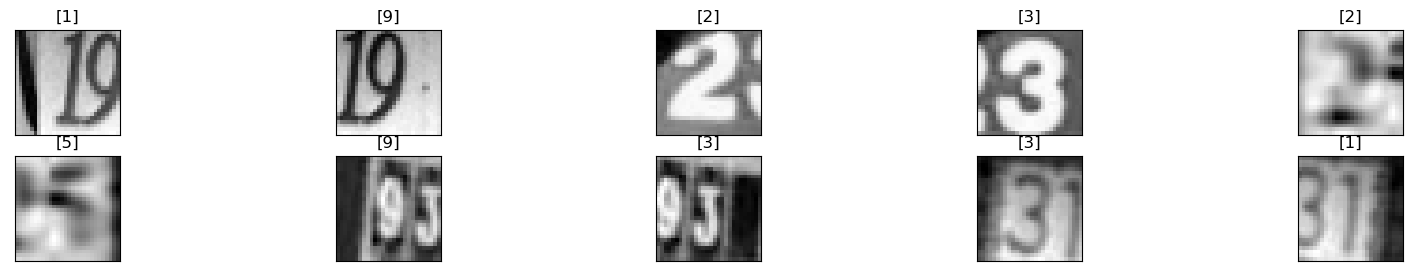

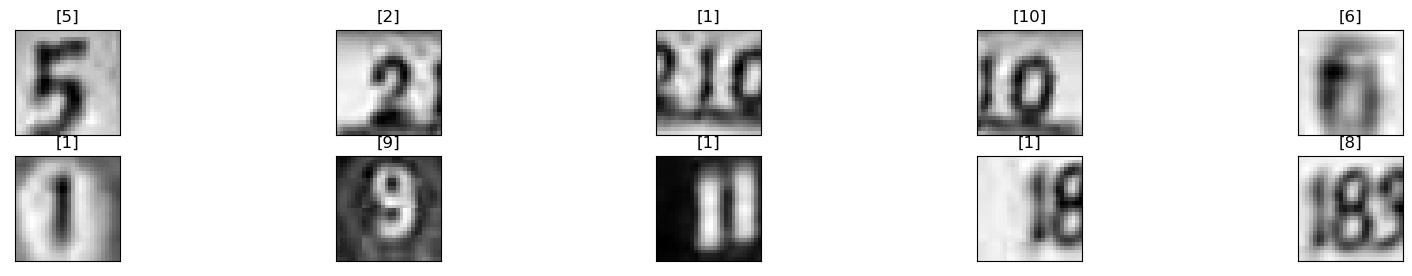

In [20]:
# Plot input image and label
plt.rcParams["figure.figsize"] = (20,3)
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0], cmap='gray')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])
plot_images(x_train_svhn, y_train, 2, 5)
plot_images(x_test_svhn, y_test, 2, 5)

### Use Basemodel as pretrained model

In [21]:
#Directly using the Base model on SVHN test data
pre_test_loss, pre_test_acc = base_model.evaluate(x_test_svhn,  y_test_svhn)
print(pre_test_acc)

814/814 [==============================] - 4s 3ms/step - loss: 11.9256 - accuracy: 0.1166
0.11662568897008896


### Train the whole model again with SVHN data

In [22]:
# Clone the Base model and Fit the New model to training data and then evaluate on test data
new_model = clone_model(base_model)
base_weights = base_model.get_weights()
new_model.set_weights(base_weights)
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=5,
        mode='max',
        verbose=1)

new_history = new_model.fit(x_train_svhn, y_train_svhn, batch_size=1024, epochs=50, verbose=1, 
                   validation_split=0.2,callbacks=[early_stopping])


Epoch 1/50


2023-04-16 14:07:46.283473: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


58/58 [==============================] - 8s 63ms/step - loss: 2.1935 - accuracy: 0.3132 - val_loss: 1.4964 - val_accuracy: 0.5418
Epoch 2/50
58/58 [==============================] - 3s 56ms/step - loss: 1.1438 - accuracy: 0.6137 - val_loss: 0.8796 - val_accuracy: 0.7412
Epoch 3/50
58/58 [==============================] - 3s 55ms/step - loss: 0.7906 - accuracy: 0.7472 - val_loss: 0.6000 - val_accuracy: 0.8316
Epoch 4/50
58/58 [==============================] - 3s 52ms/step - loss: 0.6525 - accuracy: 0.7974 - val_loss: 0.4626 - val_accuracy: 0.8648
Epoch 5/50
58/58 [==============================] - 3s 55ms/step - loss: 0.5676 - accuracy: 0.8266 - val_loss: 0.4133 - val_accuracy: 0.8819
Epoch 6/50
58/58 [==============================] - 3s 55ms/step - loss: 0.5131 - accuracy: 0.8437 - val_loss: 0.3762 - val_accuracy: 0.8898
Epoch 7/50
58/58 [==============================] - 3s 53ms/step - loss: 0.4724 - accuracy: 0.8575 - val_loss: 0.3691 - val_accuracy: 0.8924
Epoch 8/50
58/58 [======

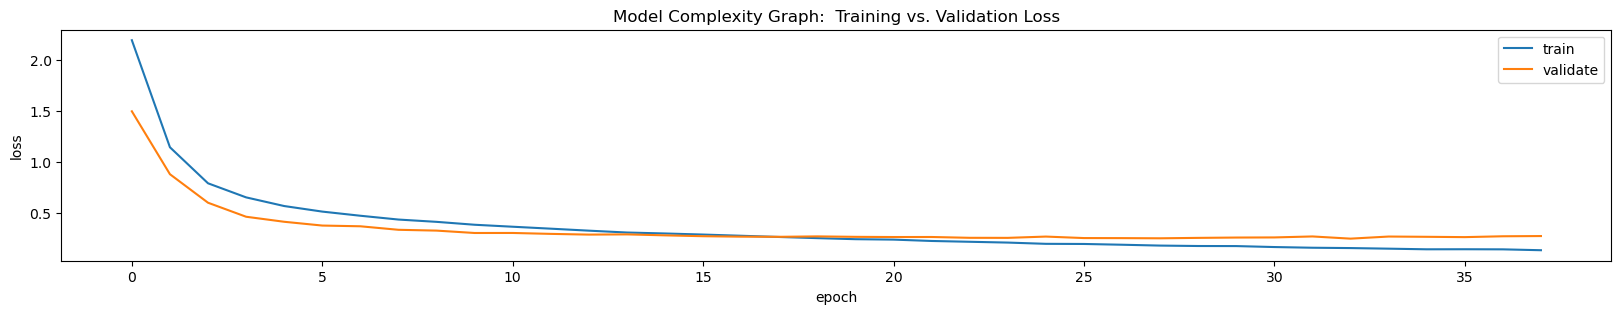

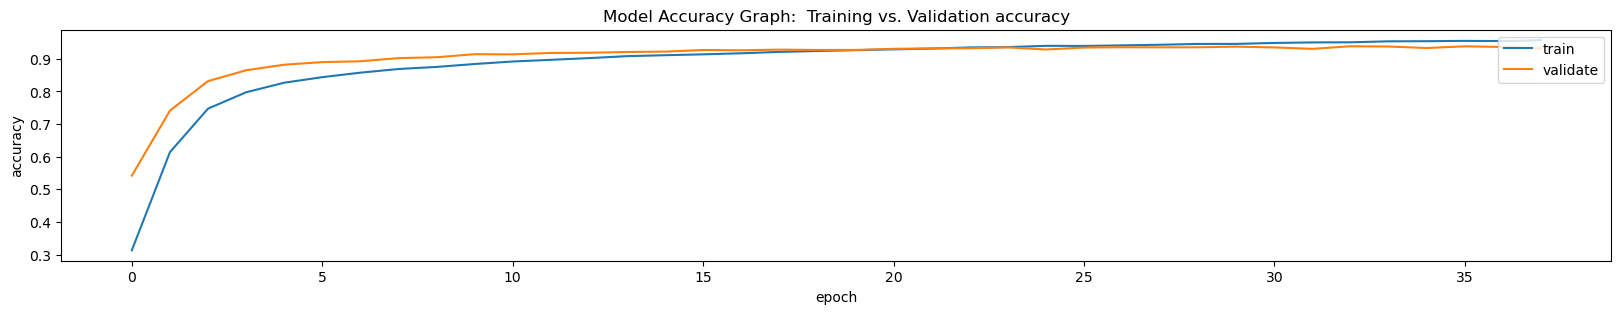

In [23]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'
plt.figure(1)
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.figure(2)
plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [24]:
#Evaluate test data based on above training
new_test_loss, new_test_acc = new_model.evaluate(x_test_svhn,  y_test_svhn)
print("Accuracy of Test data with training the cloned model is: ",new_test_acc)

814/814 [==============================] - 3s 3ms/step - loss: 0.2869 - accuracy: 0.9294
Accuracy of Test data with training the cloned model is:  0.9294329881668091


### Transfer Learning with Freezing Layers

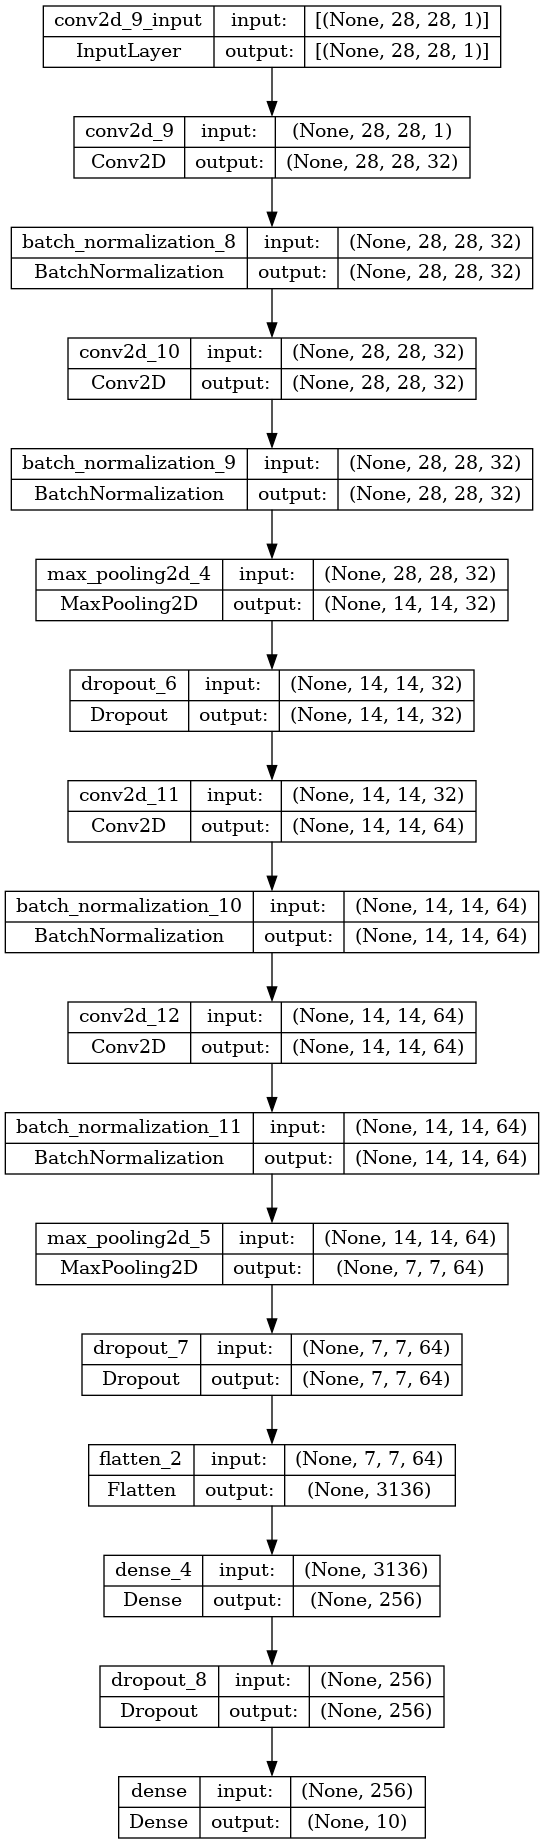

In [25]:
# Create the transfer learning model by copying the layers from the base model and freezing them
transfer_model = Sequential([
    *base_model.layers[:-1],  # Copy all the layers from the base model except the last softmax layer
    Dense(10, activation='softmax')  # Add a new softmax layer for the SVHN dataset
])

plot_model(transfer_model, show_shapes=True, show_layer_names=True)

In [26]:
# Freeze the layers from the base model
for layer in transfer_model.layers:
    if(layer in transfer_model.layers[-3:]):
        layer.trainable = True
    else:
        layer.trainable = False
        
#Module to output colorful statements
from termcolor import colored  # didnt work as expected

#Check which layers have been frozen
for layer in transfer_model.layers:
    print(colored(layer.name, 'blue'))
    print(colored(layer.trainable, 'red'))

conv2d_9
False
batch_normalization_8
False
conv2d_10
False
batch_normalization_9
False
max_pooling2d_4
False
dropout_6
False
conv2d_11
False
batch_normalization_10
False
conv2d_12
False
batch_normalization_11
False
max_pooling2d_5
False
dropout_7
False
flatten_2
False
dense_4
True
dropout_8
True
dense
True


In [27]:
# Compile the transfer learning model
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# callback option

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=5,
        mode='max',
        verbose=1)

# Train the transfer learning model with SVHN data
history = transfer_model.fit(x_train_svhn, y_train_svhn, batch_size=1024, epochs=50, verbose=1, 
                   validation_split=0.2, callbacks=[learning_rate_reduction, early_stopping])


Epoch 1/50


2023-04-16 14:10:13.164190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


58/58 [==============================] - 2s 22ms/step - loss: 2.2946 - accuracy: 0.3490 - val_loss: 1.1854 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 2/50
58/58 [==============================] - 1s 20ms/step - loss: 1.2923 - accuracy: 0.5714 - val_loss: 0.8868 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 3/50
58/58 [==============================] - 1s 17ms/step - loss: 1.1053 - accuracy: 0.6397 - val_loss: 0.7651 - val_accuracy: 0.7731 - lr: 0.0010
Epoch 4/50
58/58 [==============================] - 1s 17ms/step - loss: 1.0175 - accuracy: 0.6709 - val_loss: 0.7178 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 5/50
58/58 [==============================] - 1s 17ms/step - loss: 0.9694 - accuracy: 0.6895 - val_loss: 0.6831 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 6/50
58/58 [==============================] - 1s 17ms/step - loss: 0.9350 - accuracy: 0.6984 - val_loss: 0.6517 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 7/50
58/58 [==============================] - 1s 17ms/step - loss: 0.8952 - accur

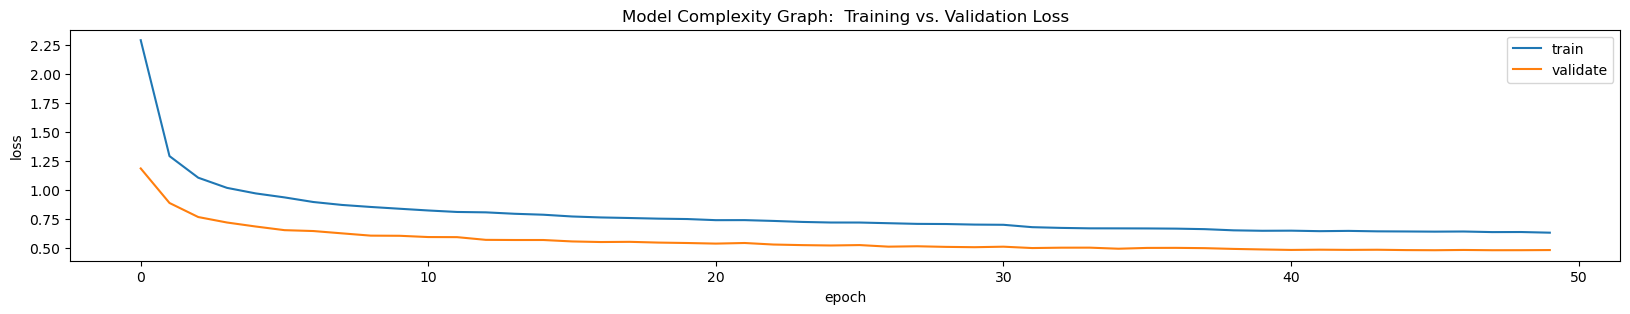

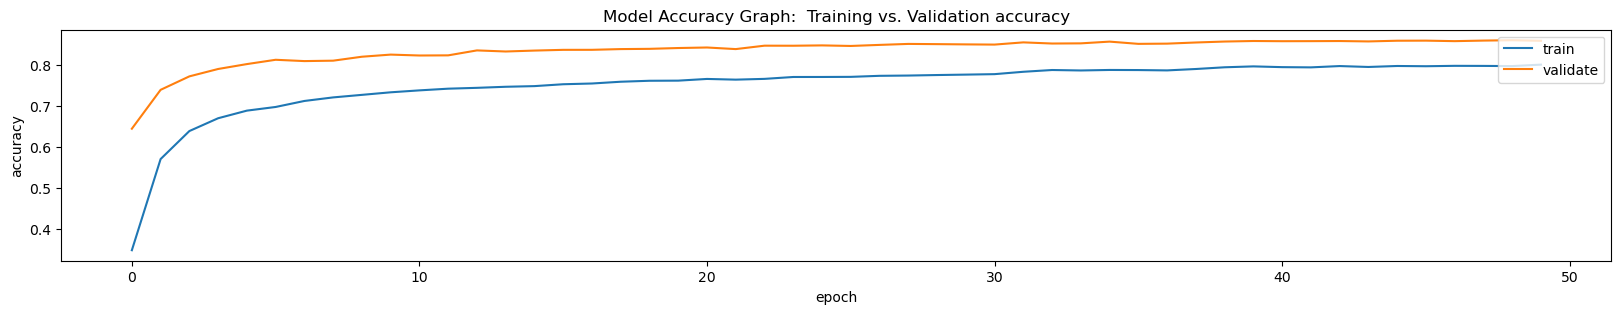

In [28]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

## Prediction on Test data

In [29]:
test_loss, test_acc = transfer_model.evaluate(x_test_svhn,  y_test_svhn)
print("Accuracy of Test data with frozen layers of the base model and training with last layes is: ",test_acc)

814/814 [==============================] - 3s 3ms/step - loss: 0.5053 - accuracy: 0.8538
Accuracy of Test data with frozen layers of the base model and training with last layes is:  0.8537953495979309


3/3 [==============================] - 0s 11ms/step


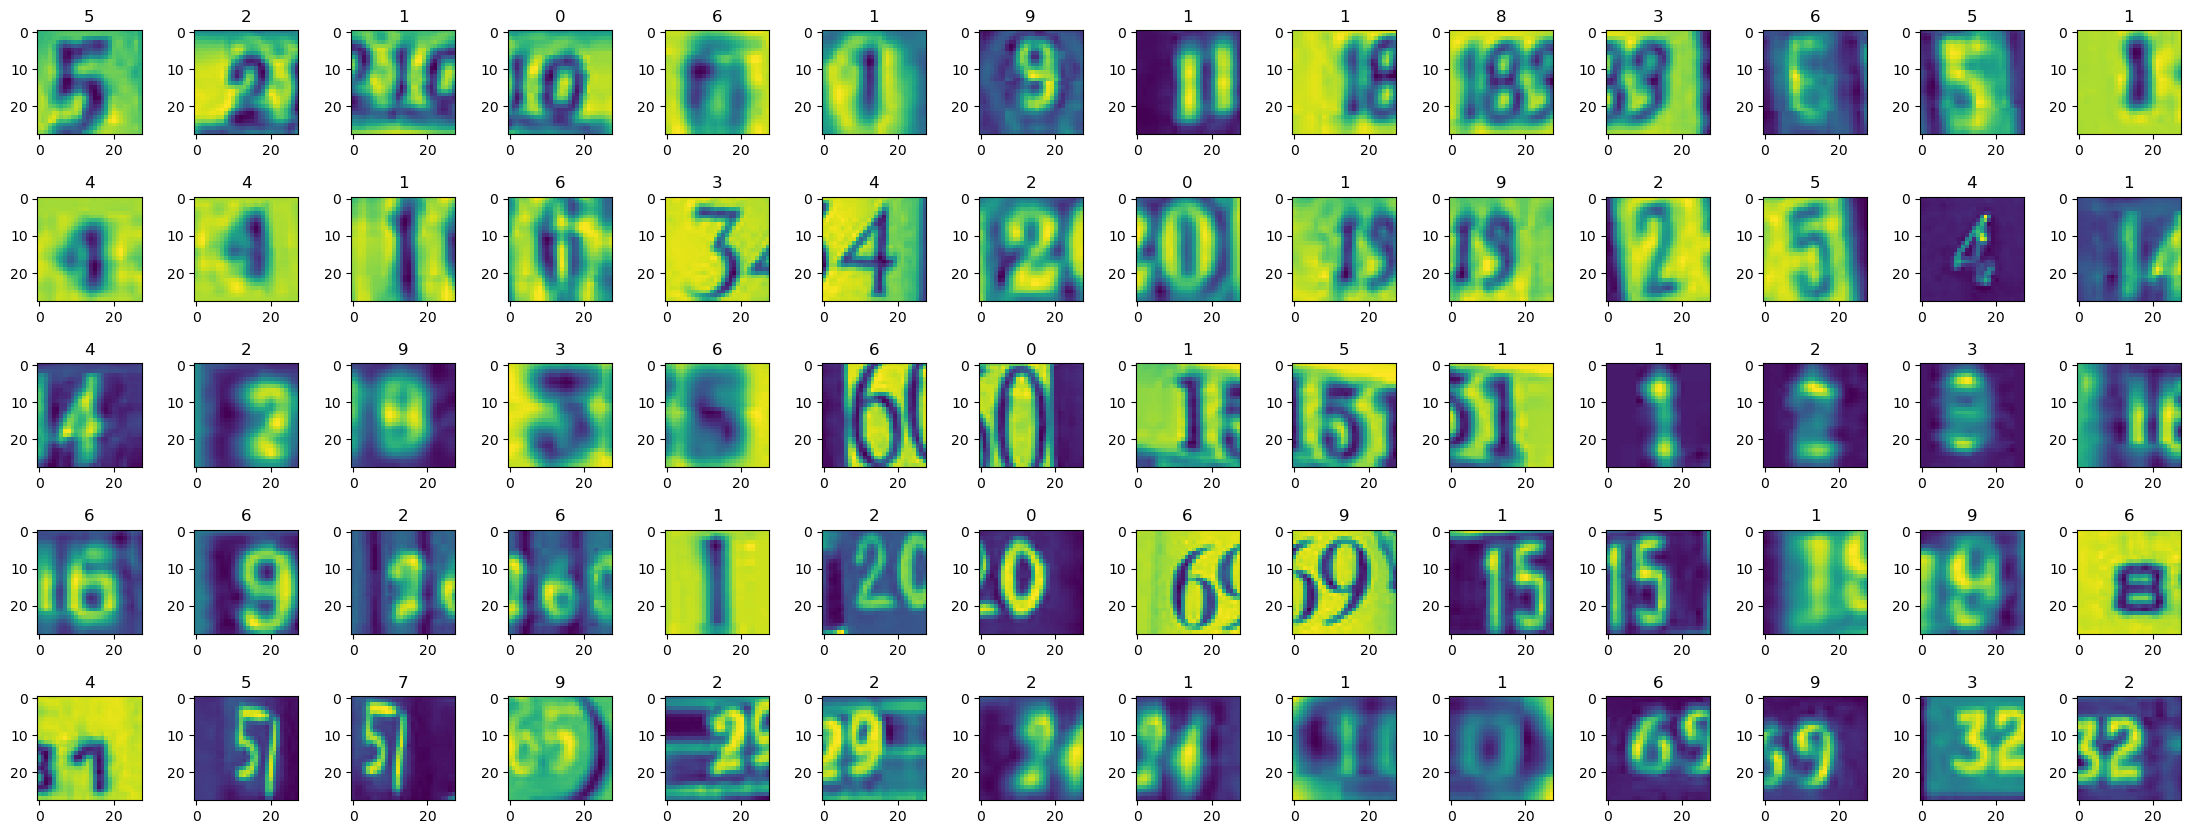

In [30]:
# predicted class
num_rows = 5
num_cols = 14
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9','0']
sample_size = num_rows * num_cols
indices = np.arange(sample_size)
x_pred = x_test_svhn[indices,:,:]
predictions = transfer_model.predict(x_pred)
x_pred = np.squeeze(x_test_svhn[indices,:,:])
y_pred = np.argmax(predictions,axis=1)

num_images = num_rows*num_cols
plt.figure(figsize=(num_cols*2, num_rows*2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i+1)
  plt.imshow(x_pred[i])
  plt.title(classes[y_pred[i]])
